In [34]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from rflearn.env import GridWorld, WindGridWorld
from rflearn.algo import TabularQValue, TabularPolicy, Episode
from rflearn.algo.episode import EpisodeStep
from rflearn.algo import MCIteration
from rflearn.algo.td import TDIteration

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
env = GridWorld(10,10)
policy = TabularPolicy(env.S, env.A, epsilon=0.1)
qvalue = TabularQValue(env.S, env.A)
agent = TDIteration(env, qvalue, policy)
agent.fit(gamma=1, alpha=0.5)

In [248]:
def get_target(start, end):
    chunk = steps[start:min(start+n, end)]
    r = [step.r1 for step in chunk]
    gamma = agent.gamma ** np.arange(len(r))
    ret = np.dot(r, gamma)

    _, _, _, s1, is_t = chunk[-1]  # check last step of termination
    if not is_t:
        a = policy.get_action(s1)
        ret += agent.gamma**n * qvalue.get_q(s1, a)
        # pi = policy[s1]
        # val = qvalue.get_value(s1, pi)
        # ret += agent.gamma**n * val
    return ret

def update_q(start, end):
    s0, a0, _, _, _ = steps[start]

    q = qvalue.get_q(s0, a0)
    target = get_target(start, end)
    error = target - q
    tderrors.append(error)
    new_q = q + agent.alpha * error
    qvalue.set_q(s0, a0, new_q)

def reset():
    # reset all
    global steps, t, T, τ
    steps = []
    t, T = -1, np.inf
    τ = t - (n-1)


np.random.seed(2304928)
nsteps = 500000
n = 20

pbar = tqdm(total=nsteps)
reset()
tderrors = []
step_gen = agent.get_steps(nsteps)
while True:
    t += 1
    if t < T:  # while not at terminal step
        try:
            step = next(step_gen)
            pbar.update(1)
        except StopIteration:
            pbar.close()
            break

        steps.append(step)
        if step.is_terminal:
            T = t + 1
    
    τ += 1  # index for the state to be updated
    if τ >= 0:
        update_q(τ, T)

    if τ == T - 1:  # end of episode, and done updates
        reset()

100%|██████████| 500000/500000 [00:27<00:00, 17879.31it/s]


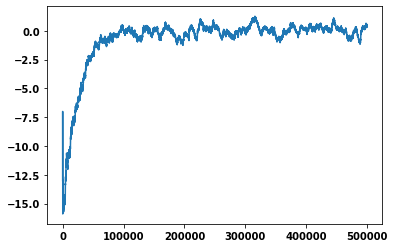

In [254]:
trace = pd.Series(tderrors)
trace.ewm(halflife=nsteps/20).mean().plot()
# trace.plot(alpha=0.4)
plt.show()

In [252]:
np.round(qvalue.get_all_values(policy).reshape(env.shape)/10)

array([[  0.,  -8., -13., -19., -18., -21., -23., -23., -23., -23.],
       [ -4.,  -8., -14., -21., -18., -19., -22., -21., -23., -21.],
       [-10., -13., -21., -22., -21., -22., -23., -22., -22., -22.],
       [-13., -16., -19., -21., -22., -22., -21., -21., -21., -21.],
       [-17., -17., -18., -21., -22., -22., -21., -19., -17., -18.],
       [-19., -19., -20., -18., -22., -21., -21., -20., -18., -16.],
       [-20., -22., -18., -15., -21., -22., -19., -19., -14., -18.],
       [-22., -20., -19., -17., -16., -19., -17., -18.,  -9., -16.],
       [-22., -21., -18., -16., -17., -15., -16., -12.,  -5.,  -9.],
       [-23., -22., -16., -16., -16., -17., -18., -12.,  -5.,   0.]])